In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# openai api key
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
NOVITA_API_KEY = os.getenv("NOVITA_API_KEY")

In [3]:
# extraxt and store the doc in text file
import os
import requests
import PyPDF2
from io import BytesIO

pdf_url = "https://arxiv.org/pdf/2510.25804" # cs paper 'BEYOND LENGTH: QUANTIFYING LONG-RANGE IN-FORMATION FOR LONG-CONTEXT LLM PRETRAININGDATA'
response = requests.get(pdf_url)
response.raise_for_status()
pdf_in_memory = BytesIO(response.content) # store data in ram
reader = PyPDF2.PdfReader(pdf_in_memory)

text = ''
for page in reader.pages:
    text += page.extract_text()

file_name = "research_paper.txt"
file_path = os.path.join('data', file_name)
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, "w") as f: f.write(text.strip())


# questions and ground truth
QUESTIONS = [
    'Why is simply using "long-length data" insufficient for effective long-context LLM pretraining, and what fundamental difference does the paper identify between merely long data and "long-context data"?',
    'Explain the simple yet powerful principle upon which the LongFilter data selection method is founded. How is this principle operationalized as a measurable "information gain"?',
    'The paper views existing long-context pretraining strategies as a "0-to-1" step. Explain the "1-to-2" step proposed by the authors and how it improves the learning signal.',
    'Describe the ideal theoretical tool and its equivalent formulation used by LongFilter to quantify the effect of the extended context $E$ on the next token prediction.',
    'Reformulate the final LongFilter score (Equation 7) in terms of the standard per-token cross-entropy loss and explain its loss-based interpretation.',
    'Summarize the key findings from the experiments on the HELMET, LongBench, and RULER benchmarks, comparing LongFilter’s overall performance against the ProLong and LongWanjuan baselines.',
    'What was the experimental setup for LongFilter, including the base model, the target context length extension, and the specific context window settings used for scoring?',
    'Identify the specific LongBench and RULER sub-tasks (categories) where LongFilter\'s advantage was particularly pronounced, and explain the likely reason for this benefit.'
]
GROUND_TRUTHS = [
    "Sequence length alone fails to differentiate genuinely **long-context-dependent data** from lengthy sequences dominated by repetitions, independent segments, or tokens predictable from only **local context**. The paper identifies that **long-length data** often lacks meaningful long-distance dependencies, meaning the next tokens can be inferred from short contexts, making it inefficient for long-context pretraining. For example, a collection of poems (long-length) lacks inter-poem dependencies, while interconnected chapters in a textbook (long-context) require access to preceding information.",
    "The simple yet powerful principle is: **data is valuable for long-context training only if the long context actually helps the model make better predictions.** This principle is operationalized by measuring the **information gain** provided by the extended context. The score's formulation is derived from the **Kullback-Leibler (KL) divergence** between a model’s next-token prediction distributions conditioned on a long context ($P_L$) versus a short context ($P_S$), which is computed at each token position.",
    "The paper views existing long-context pretraining strategies—which increase the proportion of long sequences—as a '0-to-1' step where the model *begins* to learn long-context dependencies. The proposed '1-to-2' step is to **further increase the proportion of sequences that genuinely require long-context understanding** by using LongFilter. This approach is beneficial because it assigns a larger learning signal to tokens that truly depend on extended context, thus improving the efficiency of pretraining.",
    "The ideal theoretical tool is **Conditional Mutual Information (CMI)**, specifically $I(T ; E | S)$, which measures the reduction in uncertainty about the target token $T$ after observing the extended context $E$, given that the short context $S$ is already known. The second, equivalent formulation expresses the CMI as the expected **Kullback-Leibler (KL) divergence** between the predictive distributions with and without the extended context: $I(T ; E | S) = E_{p(s,e)} [ D_{KL} ( p(T | S = s, E = e) \| p(T | S = s) ) ]$.",
    "Let $L^{long}_i$ and $L^{short}_i$ be the cross-entropy losses for predicting the ground-truth token $x^*_i$ given the long and short contexts, respectively: \n$$L^{long}_i = - \log p(x^*_i | x^*_{i-\ell_{Long}:i-1})$$ \n$$L^{short}_i = - \log p(x^*_i | x^*_{i-\ell_{Short}:i-1})$$\nThen, the LongFilter score is reformulated as: \n$$\text{Score}(X^*) = \frac{1}{N} \sum_{i=1}^{N} \exp(-L^{long}_i)(L^{short}_i - L^{long}_i)$$\nThis loss-based view means the score prefers examples where the **reduction in prediction loss** from using a longer context (the term $L^{short} - L^{long}$) is large, weighted by the model’s **confidence** in the prediction given the full context $(\exp(-L^{long}))$.",
    "Across the HELMET, LongBench, and RULER benchmarks, models continually pre-trained on LongFilter-selected data consistently achieved the highest overall scores and exhibited the most stable improvement compared to ProLong and LongWanjuan. LongFilter significantly improves training efficiency, with models trained on 1.5B filtered tokens achieving performance comparable to training on 3-4B unfiltered tokens. On recall tasks, LongFilter yielded up to a 10% accuracy gain when training on 1B tokens.",
    "The base model for the experiments was **LLaMA-3-8B**, which has an initial effective context length of **8K**. The continual pre-training aimed to extend this context length to **64K**. For the LongFilter scoring setup, the **short context window** was set to **4K** ($\ell_{Short}$), and the **long context window** was set to **64K** ($\ell_{Long}$). The scoring model used was Llama-3.1-8B.",
    "LongFilter's advantage was particularly pronounced in the **Synthetic tasks** on LongBench and the **structured data tasks** on RULER, specifically **MultiKey, MultiValue, and MultiQuery**. The likely reason is that these categories heavily rely on the model's ability to **leverage information from arbitrary or widely separated positions** within the context, demonstrating that the LongFilter effectively curates data rich in long-range dependencies."
]


In [ ]:
# create chroma db

from typing import List
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings


# config openaiembeddings class
embedding_model = OpenAIEmbeddings(model='text-embedding-ada-002', api_key=OPENAI_API_KEY, max_retries=1) # type: ignore


# create document chuncks (langchain Document object)
def load_and_chunk_document(file_path: str = file_path) -> List[Document]:    
    loader = TextLoader(file_path)
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=50, separators=["\n\n", "\n", " ", ""])    
    chunks = text_splitter.split_documents(documents)
    print(f"... loaded {len(documents)} document(s) and split into {len(chunks)} chunks ...")
    return chunks

document_chunks = load_and_chunk_document()


# create vector db
vector_db = Chroma.from_documents(
    documents=document_chunks, 
    embedding=embedding_model, 
    persist_directory="./_rag_db_chroma"
)
print(vector_db)

... loaded 1 document(s) and split into 88 chunks ...


In [5]:
# config llm (llama 3.1) and tokenizer
from langchain_openai import ChatOpenAI

# novita / openai api setup
NOVITA_API_BASE = 'https://api.novita.ai/openai'
LLM_MODEL = 'meta-llama/llama-3.1-8b-instruct'

# experimental setup
TEMPERATURE=0.2
TOP_P=1e-10
TOP_K=1.0
MAX_RESPONSE_TOKENS = 2048 # safe ceiling on output tokens
CONTEXT_WINDOWS = [2048, 4096, 6144, 8192]
PROMPT_OVERHEAD = 500 # esimate tokens for questions added to the prompt


# config llama 3.1
llm = ChatOpenAI(
    api_key=NOVITA_API_KEY, # type: ignore
    base_url=NOVITA_API_BASE,
    model=LLM_MODEL,
    max_retries=1,
    temperature=TEMPERATURE,
    top_p=TOP_P,
    max_completion_tokens=MAX_RESPONSE_TOKENS,
)
print(f'... llm configured using model: {LLM_MODEL} ...')


import tiktoken
tokenizer = tiktoken.encoding_for_model("gpt-4")
print(f'... tokenizer configured using gpt-4 ...')

... llm configured using model: meta-llama/llama-3.1-8b-instruct ...
... tokenizer configured using gpt-4 ...


In [6]:
# config prompt template
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an expert answer generator. Based ONLY on the following context, answer the complex, multi-hop question from the user."
    "If you cannot find the answer in the provided context, state that you do not have enough information."
    "\n\nContext:\n{context}"
)
rag_prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{question}")
])


In [7]:
from typing import List
from operator import itemgetter
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser


# util func 1 to format the retrieved documents into a single, clean string for the prompt
def _format_docs(docs: List[Document]) -> str:
    return "\n\n".join(doc.page_content for doc in docs)


# util func 2 to trunc docs based on the given context window size
def _truncate_doc_list(doc_list: List[Document], max_tokens_for_docs: int) -> List[Document]:
    context_list: List[Document] = list()
    current_tokens = 0
    for doc in doc_list:
        doc_tokens = len(tokenizer.encode(doc.page_content))
        if current_tokens + doc_tokens > max_tokens_for_docs:
            break
        context_list.append(doc)
        current_tokens += doc_tokens
    return context_list


# create rag chain
def create_rag_chain(
        llm,
        max_doc_tokens: int, # for exp - context window size
        vector_db: Chroma = vector_db, 
        k: int = 50, 
        prompt_template: ChatPromptTemplate = rag_prompt_template
    ):
    
    # define the retriever component from the vector db (storing docs)
    retriever = vector_db.as_retriever(search_kwargs={'k': k})

    # experiment setup - prune context window (input)
    token_pruner = RunnableLambda(lambda doc_list: _truncate_doc_list(doc_list=doc_list, max_tokens_for_docs=max_doc_tokens)) # type: ignore

    # sub-chain for retrieving docs (max. context window) -> returns list[Document]
    retrieved_docs = (
        itemgetter('question')
        | retriever
        | token_pruner
    )

    rag_answer_chain = (
        RunnablePassthrough.assign(context=itemgetter('retrieved_docs') | RunnableLambda(_format_docs))
        | prompt_template       # feed the mapped inputs into the prompt template 
        | llm                   # pass the prompt to the llm
        | StrOutputParser()     # parse the final output message to a plain string
    )

    # pass the question amd retrieved_docs to the rag_answer_chain. 
    rag_chain = RunnableParallel(retrieved_docs=retrieved_docs, question=itemgetter('question') ).assign(answer=rag_answer_chain)    
    print('... rag chain created successfully ...')
    
    
    return rag_chain

    # rag_chain generates an answer in a format: {'retrieved_docs': List[Document], 'question': str, 'answer': str}

In [8]:
# llm judge
import json
from typing import List, Tuple
from openai import OpenAI
from pydantic import BaseModel, Field


# format llm judge response
class LLMJudgeScores(BaseModel):
    factuality: int = Field(..., description="score from 1 to 5 for factual consistency with the source document")
    coherence: int = Field(..., description="Score from 1 to 5 for logical flow and structural organization of the response")


def invoke_llm_judge(predictions: List[str], references: List[str], sources: List[str]) -> Tuple[List[int], List[int]]:
    llm_judge = OpenAI(api_key=OPENAI_API_KEY)
    factuality_scores = []
    coherence_scores = []

    SYSTEM_PROMPT = (
        "You are an expert evaluator. Your task is to score a generated answer based on two criteria: "
        "Factuality/Faithfulness and Response Coherence. You must only output a single JSON object. "
        "The scoring scale is 1 (Poor) to 5 (Excellent) for both metrics. "
        "Strictly adhere to the following JSON schema:\n"
        "{'factuality': int, 'coherence': int}"
    )

    # scoring
    for i, (prediction, reference, source) in enumerate(zip(predictions, references, sources)):
        print(f"-> scoring response {i+1}/{len(predictions)} with gpt-4o...")
        
        user_prompt = f"""
        **Factuality/Faithfulness:** Score the response (1-5) based on factual consistency with the provided source document.
        - 1: Fails to address the question or contains major factual errors not supported by the source.
        - 5: Entirely accurate and directly supported by the source document.
        
        **Response Coherence:** Score the response (1-5) based on its logical flow and structural organization.
        - 1: Disorganized, confusing structure, abrupt transitions.
        - 5: Perfectly logical flow, easy to read, and well-organized.
        ---
        **Source Document:**
        {source}

        **Ground Truth Answer (Reference):**
        {reference}

        **Generated RAG Response (Prediction):**
        {prediction}
        ---
        Your JSON output MUST ONLY contain the scores for 'factuality' and 'coherence'.
        """
        

        res = llm_judge.chat.completions.create(
            model='gpt-4o',
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt},
            ],
            response_format={"type": "json_object"} # return json
        )
        json_str = res.choices[0].message.content
        scores_data = json.loads(json_str) # type: ignore 
        
        scores =LLMJudgeScores(**scores_data)
        factuality_scores.append(scores.factuality)
        coherence_scores.append(scores.coherence)

    return factuality_scores, coherence_scores

In [9]:
import time
from typing import Tuple, List
from evaluate import load


def compute_bert_and_rouge(predictions: List[str], references: List[str]) -> Tuple[float, float]:
    bert_score_metric = load("bertscore")
    berts = bert_score_metric.compute(predictions=predictions, references=references, lang="en", model_type="bert-base-uncased")
    avg_bert = sum(berts['f1']) / len(berts['f1']) # type: ignore

    rouge_metric = load("rouge")
    rouges = rouge_metric.compute(predictions=predictions, references=references, rouge_types=['rougeL'])
    rouge = rouges['rougeL'] # type: ignore
    return avg_bert, rouge


# invoke the rag chain (retrieval + response generation)
results = dict()

for max_doc_tokens in CONTEXT_WINDOWS:
    rag_chain = create_rag_chain(llm=llm, max_doc_tokens=max_doc_tokens, vector_db=vector_db)
    predictions, times, sources = list(), list(), list()

    for i, q in enumerate(QUESTIONS):
        start_time = time.time()
        output = rag_chain.invoke({"question": q})
        end_time = time.time()
        final_answer, context = output['answer'], output['retrieved_docs']
        context_string = "\n---\n".join([doc.page_content for doc in context]) 
        op_time = end_time - start_time

        predictions.append(final_answer)
        times.append(op_time)
        sources.append(context_string)

        print("\n=======================================================")
        print(f'Context window: {max_doc_tokens:,}')
        print(f"Query {i + 1}:\n{q}")
        print(f'RAG response:\n{final_answer}')
        print(f'total time: {op_time:.2f}s')
        print("=======================================================")


    # evaluate (metrics)
    bert, rouge_l = compute_bert_and_rouge(predictions=predictions, references=GROUND_TRUTHS)

    # llm judge
    factuality_scores, coherence_scores = invoke_llm_judge(predictions=predictions, references=GROUND_TRUTHS, sources=sources)
    
    avg_factuality = sum(factuality_scores) / len(factuality_scores)
    avg_coherence = sum(coherence_scores) / len(coherence_scores)

    # store the reults 
    results[max_doc_tokens] = dict(
        predictions=predictions, times=times, bert=bert, rouge_l=rouge_l, factuality=avg_factuality, coherence=avg_coherence
    )


... rag chain created successfully ...

Context window: 2,048
Query 1:
Why is simply using "long-length data" insufficient for effective long-context LLM pretraining, and what fundamental difference does the paper identify between merely long data and "long-context data"?
RAG response:
According to the provided context, simply using "long-length data" is insufficient for effective long-context LLM pretraining because it does not guarantee the presence of contextual information in the extended content. The paper identifies a fundamental difference between merely long data and "long-context data" as follows:

Long-length data does not necessarily mean long-context data. Some long-length texts simply lack contextual information in their extended content. For instance, consider books and poetry collections. Individual poems, even by the same author, often lack inter-poem dependencies, and their relatively short length makes them suitable for short-context models. In contrast, textbooks are

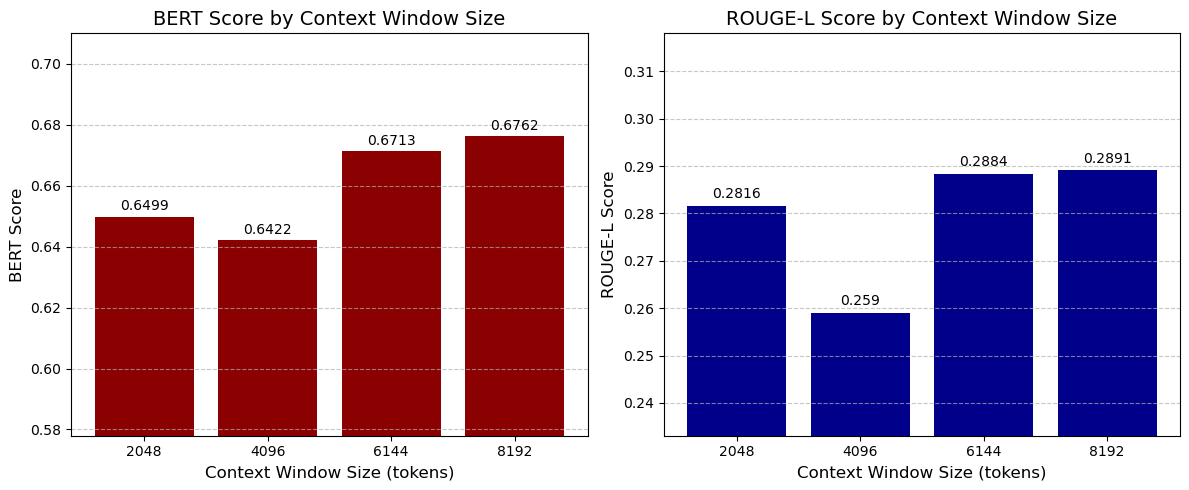

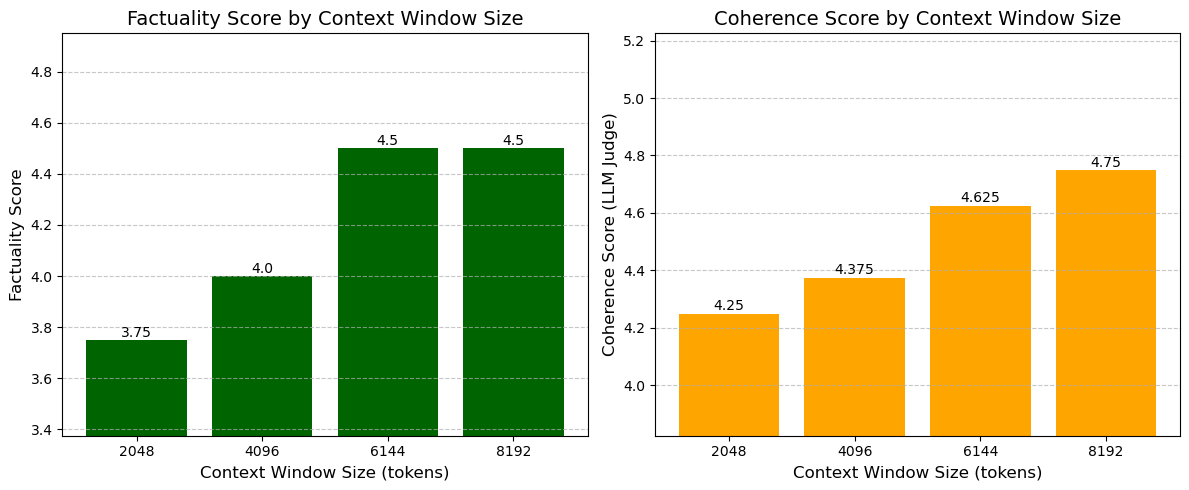

In [18]:
import pandas as pd
import matplotlib.pyplot as plt


context_windows = list(results.keys())
bert_scores = [results[k]['bert'] for k in context_windows]
rouge_l_scores = [results[k]['rouge_l'] for k in context_windows]

factuality_scores = [results[k]['factuality'] for k in context_windows]
coherence_scores = [results[k]['coherence'] for k in context_windows]


df = pd.DataFrame({
    'Context Window Size (tokens)': context_windows,
    'BERT Score': bert_scores,
    'ROUGE-L Score': rouge_l_scores,
    'Factuality Score (LLM Judge)': factuality_scores,
    'Coherence Score (LLM Judge)': coherence_scores,
})
df['Context Window Size (tokens)'] = df['Context Window Size (tokens)'].astype(str)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bars_bert = plt.bar(df['Context Window Size (tokens)'], df['BERT Score'], color='darkred')
for bar in bars_bert:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')
plt.title('BERT Score by Context Window Size', fontsize=14)
plt.xlabel('Context Window Size (tokens)', fontsize=12)
plt.ylabel('BERT Score', fontsize=12)
plt.ylim(min(df['BERT Score']) * 0.9, max(df['BERT Score']) * 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
bars_rouge = plt.bar(df['Context Window Size (tokens)'], df['ROUGE-L Score'], color='darkblue')
for bar in bars_rouge:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.title('ROUGE-L Score by Context Window Size', fontsize=14)
plt.xlabel('Context Window Size (tokens)', fontsize=12)
plt.ylabel('ROUGE-L Score', fontsize=12)
plt.ylim(min(df['ROUGE-L Score']) * 0.9, max(df['ROUGE-L Score']) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bars_rouge = plt.bar(df['Context Window Size (tokens)'], df['Factuality Score (LLM Judge)'], color='darkgreen')
for bar in bars_rouge:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.title('Factuality Score by Context Window Size', fontsize=14)
plt.xlabel('Context Window Size (tokens)', fontsize=12)
plt.ylabel('Factuality Score', fontsize=12)
plt.ylim(min(df['Factuality Score (LLM Judge)']) * 0.9, max(df['Factuality Score (LLM Judge)']) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.subplot(1, 2, 2)
bars_rouge = plt.bar(df['Context Window Size (tokens)'], df['Coherence Score (LLM Judge)'], color='orange')
for bar in bars_rouge:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.title('Coherence Score by Context Window Size', fontsize=14)
plt.xlabel('Context Window Size (tokens)', fontsize=12)
plt.ylabel('Coherence Score (LLM Judge)', fontsize=12)
plt.ylim(min(df['Coherence Score (LLM Judge)']) * 0.9, max(df['Coherence Score (LLM Judge)']) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

